## Import & Data Load

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [102]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR'],
      dtype='object')

### 결측치 확인

In [103]:
train.isnull().sum().head(5)

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
dtype: int64

In [104]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR'],
      dtype='object')

In [105]:
missing_air_temperature = train[train['AIR_TEMPERATURE'].isnull()]
missing_air_temperature['AIR_TEMPERATURE']

5        NaN
8        NaN
9        NaN
10       NaN
11       NaN
          ..
367427   NaN
367428   NaN
367432   NaN
367435   NaN
367436   NaN
Name: AIR_TEMPERATURE, Length: 154365, dtype: float64

In [106]:
missing_air_temperatures = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]
missing_air_temperatures.head()

missing_air_temperatures.fillna(0)
missing_air_temperatures



,U_WIND,V_WIND,AIR_TEMPERATURE,BN
0,0.14,3.77,15.9,2.730798
1,-3.16,-6.72,24.5,4.289058
2,0.00,0.00,9.4,0.000000
3,4.34,-7.31,22.1,4.693735
4,1.92,2.31,22.8,2.345875
...,...,...,...,...
367436,NaN,NaN,NaN,NaN
367437,-0.06,0.87,17.1,1.028558
367438,-0.63,3.36,31.7,2.557156
367439,3.74,-2.44,10.8,3.055715


In [107]:
test.isnull().sum().head()

ARI_CO                0
ARI_PO                0
SHIP_TYPE_CATEGORY    0
DIST                  0
ATA                   0
dtype: int64

## Data Pre-processing

In [108]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 
                        'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# # 결측치 처리
# train.fillna(train.mean(), inplace=True)
# test.fillna(train.mean(), inplace=True)


Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


### 결측치 데이터만 따로 테이블만들기

In [109]:
missing_air_temperatures = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',"year","month","day"]]
missing_air_temperatures.head()
print(missing_air_temperatures.isnull().sum())

U_WIND             153486
V_WIND             153486
AIR_TEMPERATURE    154365
BN                 153486
year                    0
month                   0
day                     0
dtype: int64


### 결측치 데이터에서 null 값 0으로 채우기 (이유는 시간으로 정렬해서 이게 어떤 시간이 null인지 확인 위함)

In [110]:
missing_air_temperatures.fillna(0)
missing_air_temperatures.head()

,U_WIND,V_WIND,AIR_TEMPERATURE,BN,year,month,day
0,0.14,3.77,15.9,2.730798,2020,10,15
1,-3.16,-6.72,24.5,4.289058,2019,9,17
2,0.00,0.00,9.4,0.000000,2019,2,23
3,4.34,-7.31,22.1,4.693735,2020,9,18
4,1.92,2.31,22.8,2.345875,2022,8,13


### 결측치 데이터 시각화

C:\Users\User\AppData\Local\Temp\ipykernel_62636\3778912160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_air_temperatures['date'] = pd.to_datetime(missing_air_temperatures[['year', 'month', 'day']])


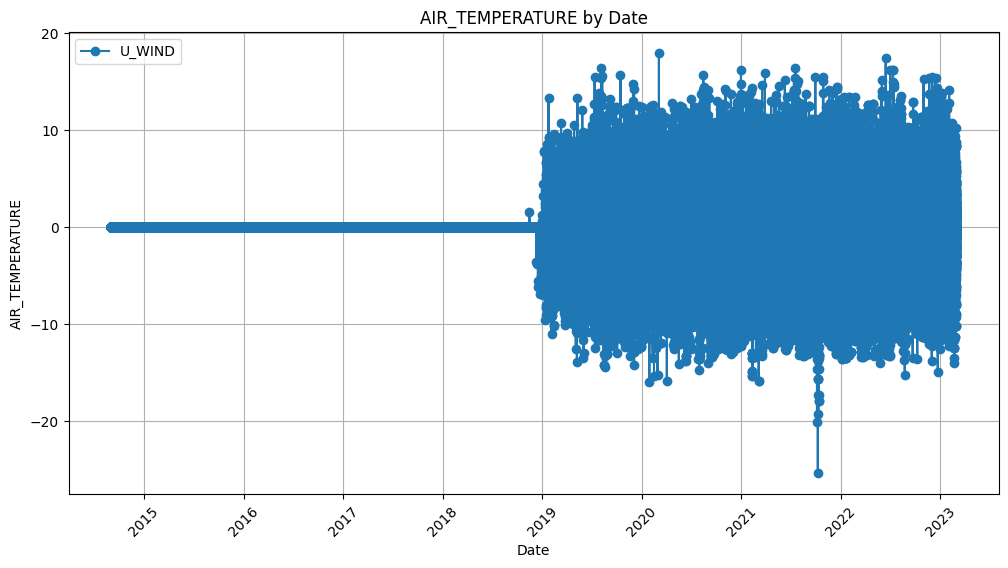

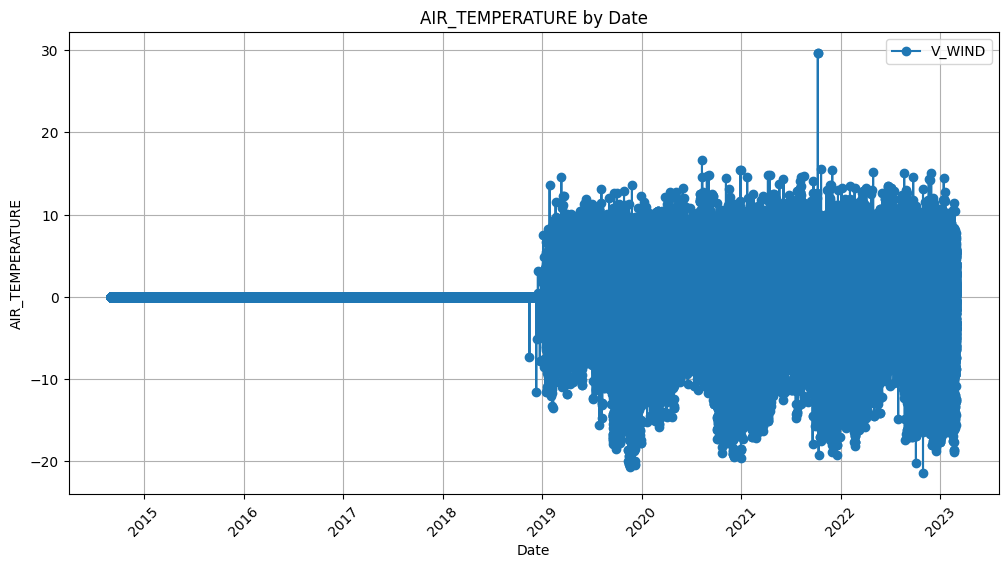

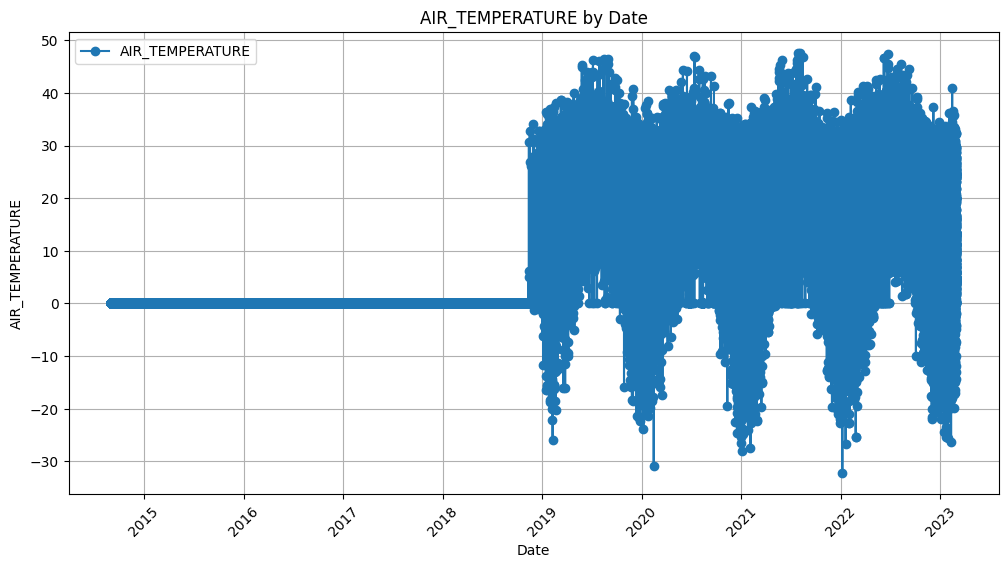

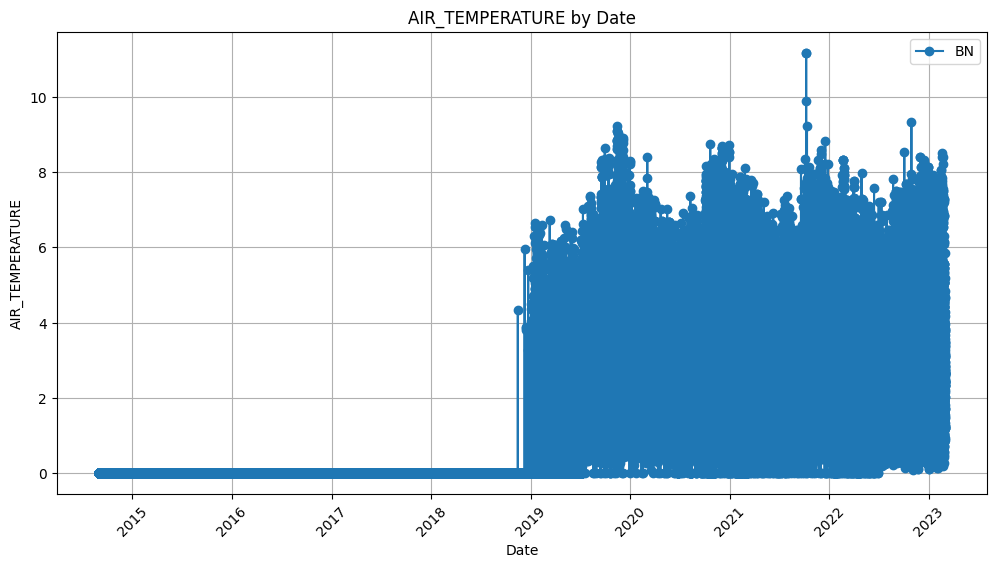

In [111]:
import matplotlib.pyplot as plt

# 'year', 'month', 'day'를 기반으로 날짜 열 생성
missing_air_temperatures['date'] = pd.to_datetime(missing_air_temperatures[['year', 'month', 'day']])

# 날짜를 기준으로 데이터 정렬
missing_air_temperatures = missing_air_temperatures.sort_values(by='date')

# 결측치를 0으로 채우기 (fillna 메서드를 사용하려면 결과를 새로운 변수에 할당해야 합니다)
missing_air_temperatures_filled = missing_air_temperatures.fillna(0)

feature = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

for i in feature :
    # 시각화 
    plt.figure(figsize=(12, 6))
    plt.plot(missing_air_temperatures_filled['date'], missing_air_temperatures_filled[i], label= i, marker='o')
    plt.xlabel('Date')
    plt.ylabel('AIR_TEMPERATURE')
    plt.title('AIR_TEMPERATURE by Date')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


### 결측치 데이터 이전 정보로 채우기

In [112]:
# # import pandas as pd

# # # 작년 데이터를 포함한 데이터프레임 생성 (예: train 데이터와 동일한 구조)
# # # 작년 데이터는 'year'를 1 감소시키면서 생성합니다.
# # last_year_data = train.copy()
# # last_year_data['year'] -= 1

# # # 결측치를 채울 함수 정의
# # def fill_missing_values(row):
# #     # 결측치가 있는 행 확인
# #     if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
# #         year = row['year']
# #         month = row['month']
# #         day = row['day']
        
# #         # 작년 동일한 month와 day를 가진 데이터 찾기
# #         last_year_same_date_data = last_year_data[(last_year_data['year'] == year) & (last_year_data['month'] == month) & (last_year_data['day'] == day)]
        
# #         if len(last_year_same_date_data) > 0:
# #             # 평균을 계산하여 결측치 채우기
# #             row['U_WIND'] = last_year_same_date_data['U_WIND'].mean()
# #             row['V_WIND'] = last_year_same_date_data['V_WIND'].mean()
# #             row['AIR_TEMPERATURE'] = last_year_same_date_data['AIR_TEMPERATURE'].mean()
# #             row['BN'] = last_year_same_date_data['BN'].mean()
    
# #     return row

# # # 결측치를 채우기 위해 각 행에 함수 적용
# # train = train.apply(fill_missing_values, axis=1)



# import pandas as pd

# # # 결측치를 채울 함수 정의
# # def fill_missing_values(row):
# #     # 결측치가 있는 행 확인
# #     if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
# #         year = row['year']
# #         month = row['month']
# #         day = row['day']
        
# #         # 현재 년도에서 이전 년도로 이동하며 결측치를 채우기
# #         while year >= 2019:  # 2020년부터 2023년까지 데이터가 있는 경우
# #             # 현재 년도에서 1 년을 감소시킵니다.
# #             year += 1
            
# #             # 현재 년도에서 결측치를 채울 데이터를 찾습니다.
# #             data_to_fill = train[(train['year'] == year) & (train['month'] == month) & (train['day'] == day)]
            
# #             if len(data_to_fill) > 0:
# #                 # 평균을 계산하여 결측치 채우기
# #                 row['U_WIND'] = data_to_fill['U_WIND'].mean()
# #                 row['V_WIND'] = data_to_fill['V_WIND'].mean()
# #                 row['AIR_TEMPERATURE'] = data_to_fill['AIR_TEMPERATURE'].mean()
# #                 row['BN'] = data_to_fill['BN'].mean()
# #                 break  # 결측치가 채워지면 루프 종료
    
# #     return row


# import pandas as pd

# # 결측치를 채울 함수 정의
# def fill_missing_values(row):
#     # 결측치가 있는 행 확인
#     if pd.isnull(row['U_WIND']) or pd.isnull(row['V_WIND']) or pd.isnull(row['AIR_TEMPERATURE']) or pd.isnull(row['BN']):
#         year = row['year']
#         month = row['month']
#         day = row['day']
        
#         # 2020년부터 2021년까지의 데이터를 가져옵니다.
#         data_to_fill = train[
#             (train['year'] >= 2020) & (train['year'] <= 2021) &
#             (train['month'] == month) & (train['day'] == day)
#         ]
        
#         if len(data_to_fill) > 0:
#             # 평균을 계산하여 결측치 채우기
#             row['U_WIND'] = data_to_fill['U_WIND'].mean()
#             row['V_WIND'] = data_to_fill['V_WIND'].mean()
#             row['AIR_TEMPERATURE'] = data_to_fill['AIR_TEMPERATURE'].mean()
#             row['BN'] = data_to_fill['BN'].mean()
    
#     return row

# # 결측치를 채우기 위해 각 행에 함수 적용
# train = train.apply(fill_missing_values, axis=1)
# test = test.apply(fill_missing_values, axis=1)

# # # train 데이터를 CSV 파일로 저장
# # train.to_csv('filled_train_data.csv', index=False)

# # # test 데이터를 CSV 파일로 저장
# # test.to_csv('filled_test_data.csv', index=False)


In [113]:
# # train 데이터를 CSV 파일로 저장
# train = pd.read_csv('filled_train_data.csv')
# train = pd.read_csv('filled_test_data.csv')


In [114]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [115]:
# train.fillna(train.mean(), inplace=True)
# test.fillna(train.mean(), inplace=True)

In [116]:
missing_air_temperaturess = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',"year","month","day"]]
missing_air_temperaturess.head()
print(missing_air_temperaturess.isnull().sum())

U_WIND             0
V_WIND             0
AIR_TEMPERATURE    0
BN                 0
year               0
month              0
day                0
dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_62636\3347533304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_air_temperaturess['date'] = pd.to_datetime(missing_air_temperaturess[['year', 'month', 'day']])


        U_WIND  V_WIND  AIR_TEMPERATURE        BN  year  month  day       date
34724     0.00    0.00              0.2  0.000000  2018     11   11 2018-11-11
355362    0.00    0.00              6.2  0.000000  2018     11   12 2018-11-12
258923    0.00    0.00             30.6  0.000000  2018     11   13 2018-11-13
352680    1.51   -7.38              5.1  4.330158  2018     11   15 2018-11-15
164382    0.00    0.00             32.8  0.000000  2018     11   16 2018-11-16


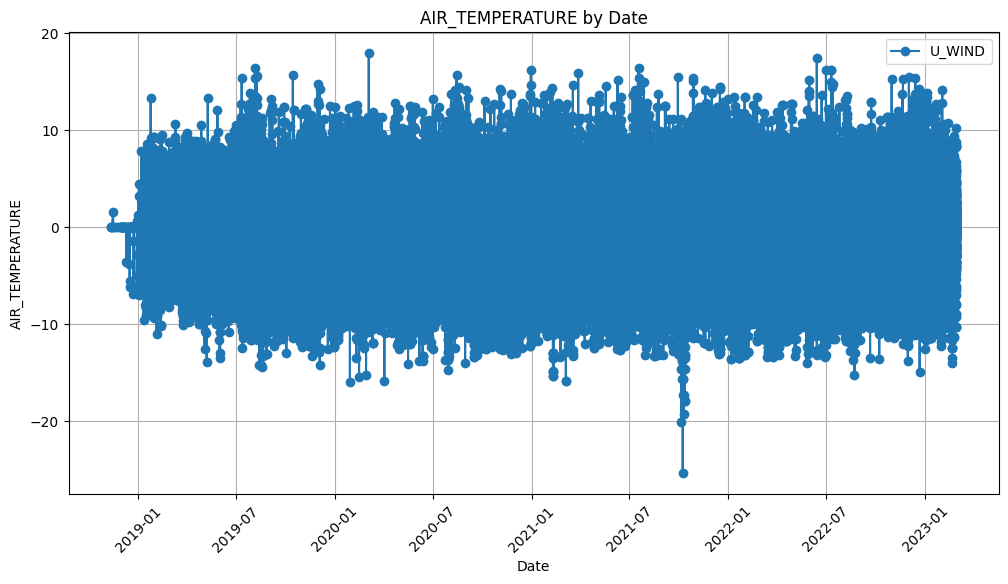

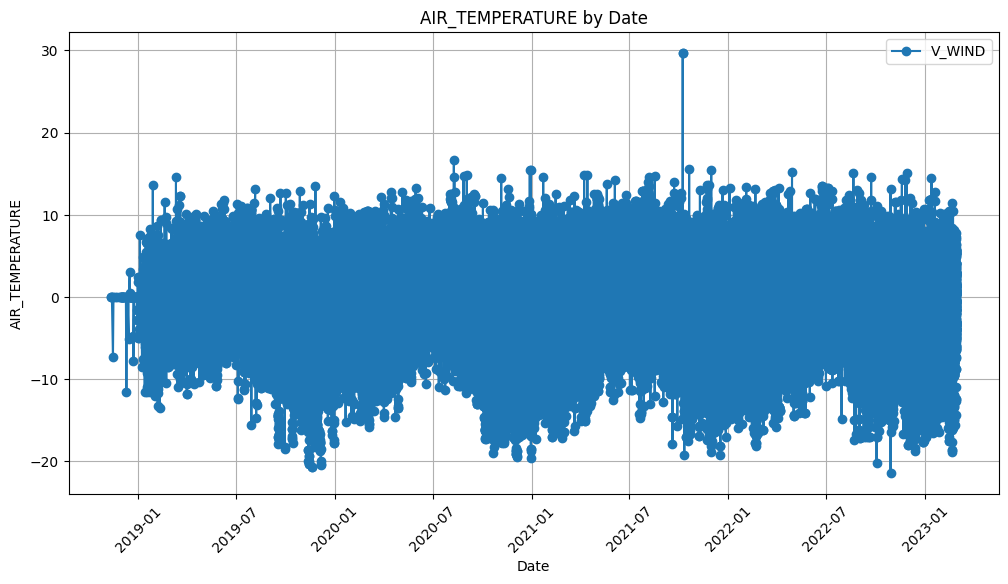

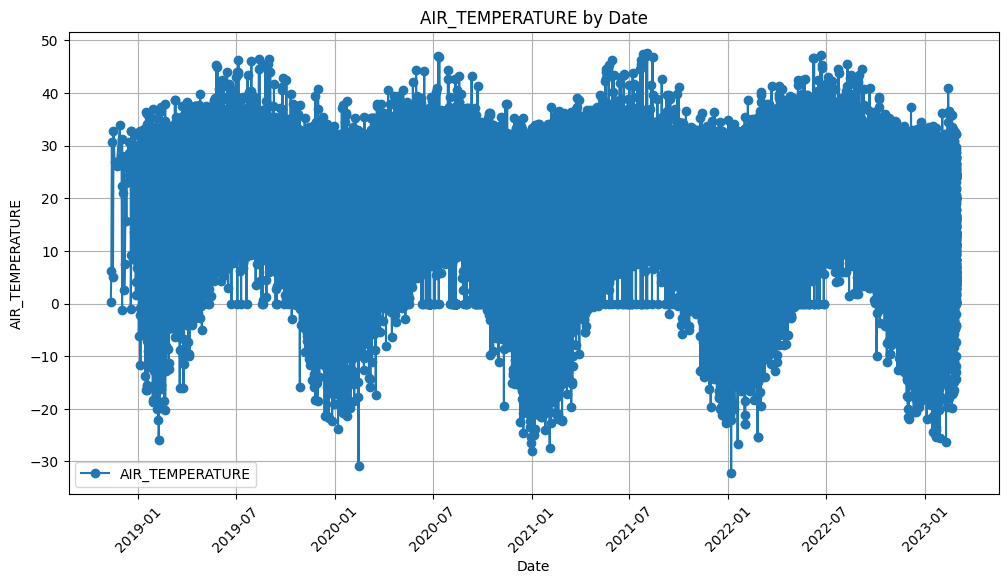

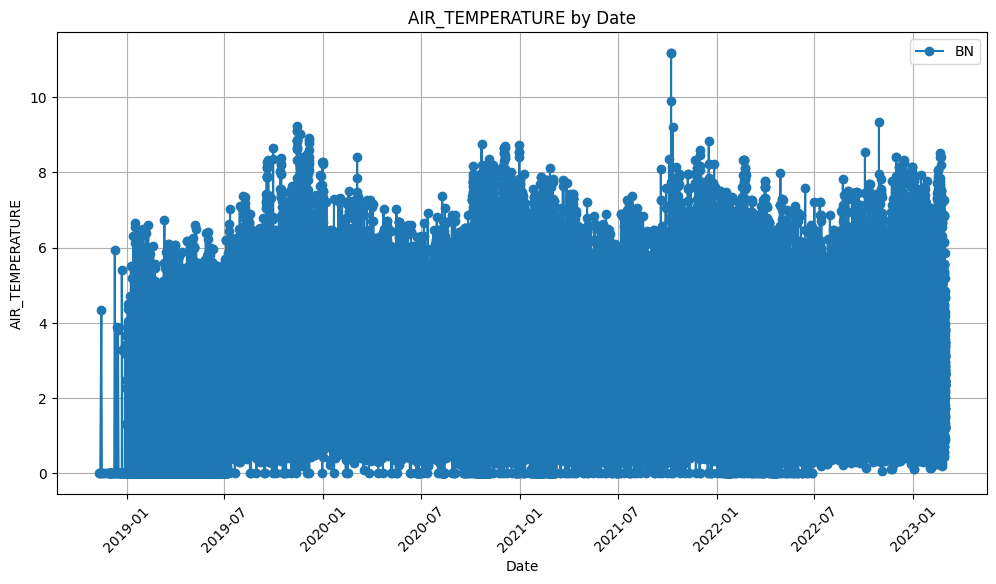

In [117]:
import matplotlib.pyplot as plt

# 'year', 'month', 'day'를 기반으로 날짜 열 생성
missing_air_temperaturess['date'] = pd.to_datetime(missing_air_temperaturess[['year', 'month', 'day']])

# 날짜를 기준으로 데이터 정렬
missing_air_temperaturess = missing_air_temperaturess.sort_values(by='date')
print(missing_air_temperaturess.head())
# 결측치를 0으로 채우기 (fillna 메서드를 사용하려면 결과를 새로운 변수에 할당해야 합니다)
missing_air_temperaturess_filled = missing_air_temperaturess

feature = ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']

for i in feature :
    # 시각화 
    plt.figure(figsize=(12, 6))
    plt.plot(missing_air_temperaturess_filled['date'], missing_air_temperaturess_filled[i], label= i, marker='o')
    plt.xlabel('Date')
    plt.ylabel('AIR_TEMPERATURE')
    plt.title('AIR_TEMPERATURE by Date')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


In [118]:
train.shape

(213075, 31)

In [119]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'CI_HOUR',
       'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

In [120]:
test.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'DUBAI', 'BRENT', 'WTI', 'BDI_ADJ', 'PORT_SIZE', 'year',
       'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')

Model Tune for CatBoostRegressor.


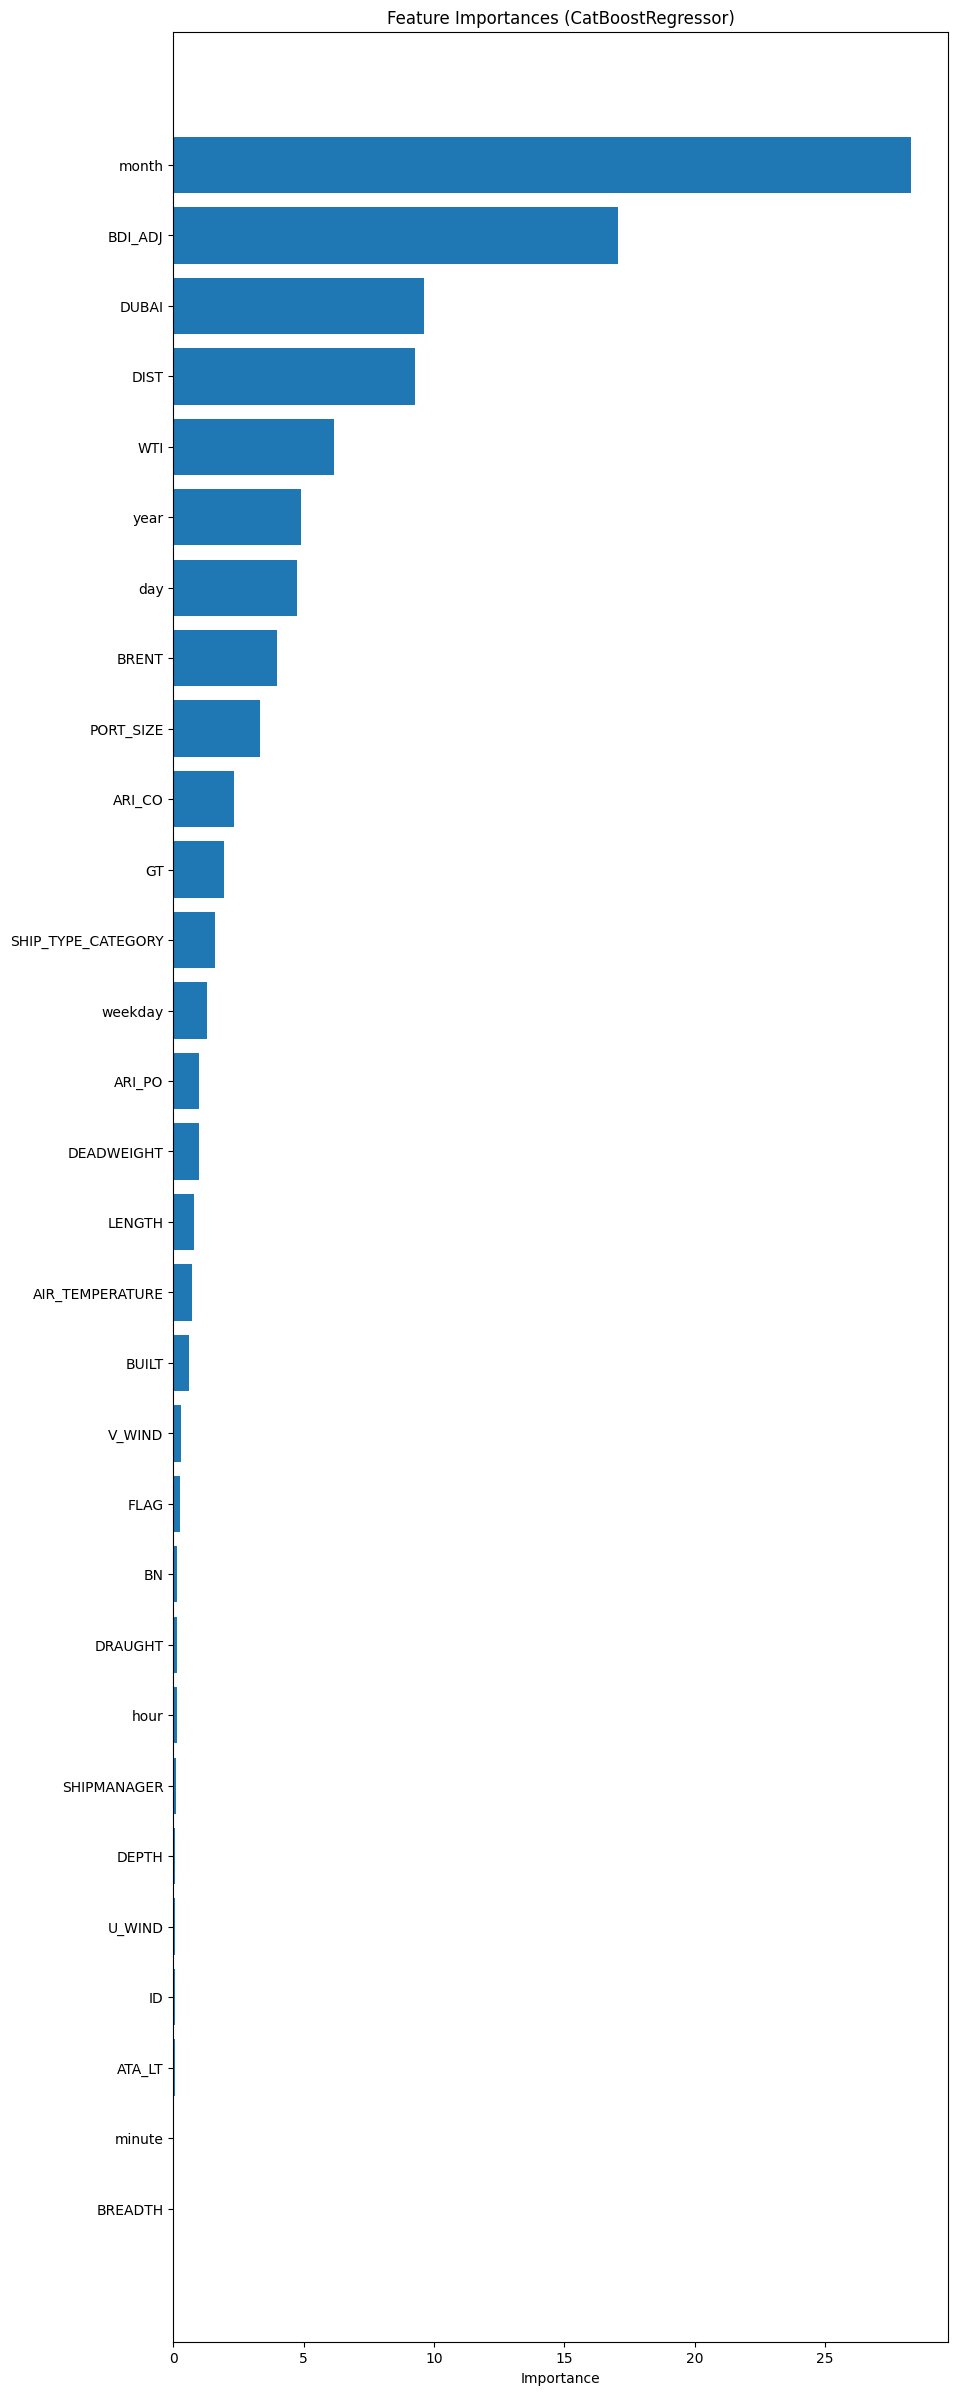

In [121]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor


# 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)



def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(catboost_model, 
                                                        'CatBoostRegressor', X_train, y_train)

In [122]:
# from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
# from catboost import CatBoostRegressor


# # 각 모델 학습 (이미 학습한 모델을 사용하려면 해당 부분을 제외하고 로드하세요)
# catboost_model = xgb.XGBRegressor(random_state=42)



# def train_and_evaluate(model, model_name, X_train, y_train):
#     print(f'Model Tune for {model_name}.')
#     model.fit(X_train, y_train)
    
#     feature_importances = model.feature_importances_
#     sorted_idx = feature_importances.argsort()

#     plt.figure(figsize=(10, len(X_train.columns)))
#     plt.title(f"Feature Importances ({model_name})")
#     plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
#     plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
#     plt.xlabel('Importance')
#     plt.show()
    
#     return model, feature_importances

# X_train = train.drop(columns='CI_HOUR')
# y_train = train['CI_HOUR']

# # Model Tune for LGBM
# lgbm_model, lgbm_feature_importances = train_and_evaluate(catboost_model, 
#                                                         'xgb.XGBRegressor', X_train, y_train)

In [123]:
threshold = 4.5 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [124]:
X_train_reduced.columns

Index(['DIST', 'DUBAI', 'WTI', 'BDI_ADJ', 'year', 'month', 'day'], dtype='object')

In [125]:
X_train_reducedss = pd.concat([X_train_reduced, y_train ], axis = 1)

In [126]:
X_train_reducedss.head()

,DIST,DUBAI,WTI,BDI_ADJ,year,month,day,CI_HOUR
0,30.736578,42.01,40.96,1407.668330,2020,10,15,3.048333
1,63.220425,67.53,59.34,2089.046774,2019,9,17,17.138611
2,90.427421,65.30,56.94,603.193047,2019,2,23,98.827500
3,0.000000,43.02,41.11,1169.853455,2020,9,18,0.000000
4,8.813725,90.45,88.11,1107.944894,2022,8,13,96.030556


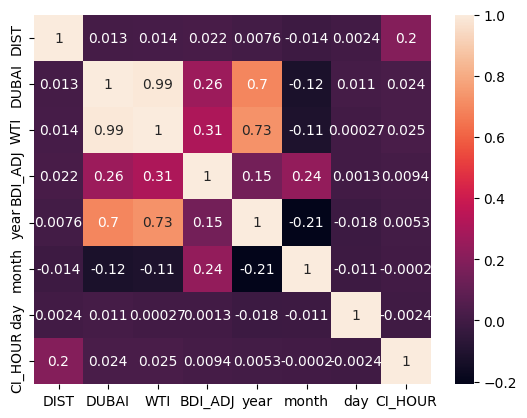

In [127]:
import seaborn as sns
sns.heatmap(X_train_reducedss.corr(), annot = True)
plt.show()

In [128]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

X= X_train_reduced

# 2차 다항식 생성
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)


X_poly.shape


(213075, 36)

In [129]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split




X = X_poly

y =  y_train


# 학습 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna를 사용하여 XGBoost 모델의 하이퍼파라미터 최적화를 수행하는 함수를 정의합니다.
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 1000, 8000),
        'max_depth':trial.suggest_int('max_depth', 5, 50),
        'min_child_weight':trial.suggest_int('min_child_weight', 5, 50),
        'gamma':trial.suggest_int('gamma', 1, 30),
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 30.0),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0] ),
        'random_state': 42,
    }
    

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**params)

    # 모델을 학습합니다.
    model.fit(X_train, y_train)

    # 검증 데이터로 예측을 수행합니다.
    y_pred = model.predict(X_valid)

    # 평균 제곱 오차(MSE)를 계산하여 최소화하도록 최적화합니다.
    mse = mean_absolute_error(y_valid, y_pred)

    return mse

# Optuna 스터디를 생성하고 실행합니다.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials= 500)  # 시행 횟수를 지정할 수 있습니다.

# 최적화된 하이퍼파라미터와 MSE 값을 출력합니다.
best_params = study.best_params
best_mse = study.best_value
print("Best Hyperparameters:", best_params)
print("Best MAE:", best_mse)


[I 2023-10-09 14:53:01,279] A new study created in memory with name: no-name-d47ccbe6-258f-40e9-a0d7-80e42c656924


C:\Users\User\AppData\Local\Temp\ipykernel_62636\1363298779.py:25: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
C:\Users\User\AppData\Local\Temp\ipykernel_62636\1363298779.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 30.0),
[I 2023-10-09 14:53:42,010] Trial 0 finished with value: 16.64053506756307 and parameters: {'n_estimators': 2674, 'max_depth': 34, 'min_child_weight': 34, 'gamma': 24, 'colsample_bytree': 0.9, 'alpha': 1.2927496511944867, 'subsample': 0.8}. Best is trial 0 with value: 16.64053506756307.
C:\Users\User\AppDa

## 모델 학습 및 특성 중요도 확인

## 특징 중요도로 부터 feature sections

In [ ]:
X_train_reduced = train.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT',  'year', 'weekday','CI_HOUR','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO'])
X_test_reduced = test.drop(columns=['BREADTH', 'DEPTH', 'DRAUGHT', 'FLAG',
                                'BN', 'BRENT', 'year', 'weekday','LENGTH',
                                'SHIP_TYPE_CATEGORY','ARI_CO', 'ARI_PO'])
y_train = train['CI_HOUR']

In [ ]:
X_train_reduced.columns

Index(['DIST', 'ID', 'BUILT', 'DEADWEIGHT', 'GT', 'SHIPMANAGER', 'U_WIND',
       'V_WIND', 'AIR_TEMPERATURE', 'ATA_LT', 'DUBAI', 'WTI', 'BDI_ADJ',
       'PORT_SIZE', 'month', 'day', 'hour', 'minute'],
      dtype='object')

<!-- ### 'DIST', 'ID', 'BUILT', 'DEADWEIGHT', 'GT', 'SHIPMANAGER', 'U_WIND',
       'V_WIND', 'AIR_TEMPERATURE', 'ATA_LT', 'DUBAI', 'WTI', 'BDI_ADJ',
       'PORT_SIZE', 'month', 'day', 'hour', 'minute' -->

In [ ]:
X_train_reduced.isnull().sum()

DIST               0
ID                 0
BUILT              0
DEADWEIGHT         0
GT                 0
SHIPMANAGER        0
U_WIND             0
V_WIND             0
AIR_TEMPERATURE    0
ATA_LT             0
DUBAI              0
WTI                0
BDI_ADJ            0
PORT_SIZE          0
month              0
day                0
hour               0
minute             0
dtype: int64

In [ ]:
y_train.isnull().sum()

0

## 초기 하이퍼파라미터 찾는 모델

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split




X = X_train_reduced

y =  y_train


# 학습 데이터와 검증 데이터로 분할합니다.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna를 사용하여 XGBoost 모델의 하이퍼파라미터 최적화를 수행하는 함수를 정의합니다.
def objective(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 3800, 8000),
        'max_depth':trial.suggest_int('max_depth', 15, 50),
        'min_child_weight':trial.suggest_int('min_child_weight', 15, 50),
        'gamma':trial.suggest_int('gamma', 1, 20),
        'learning_rate': 0.01,
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
        'nthread' : -1,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 30.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 30.0),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0] ),
        'random_state': 42,
    }
    

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**params)

    # 모델을 학습합니다.
    model.fit(X_train, y_train)

    # 검증 데이터로 예측을 수행합니다.
    y_pred = model.predict(X_valid)

    # 평균 제곱 오차(MSE)를 계산하여 최소화하도록 최적화합니다.
    mse = mean_absolute_error(y_valid, y_pred)

    return mse

# Optuna 스터디를 생성하고 실행합니다.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials= 500)  # 시행 횟수를 지정할 수 있습니다.

# 최적화된 하이퍼파라미터와 MSE 값을 출력합니다.
best_params = study.best_params
best_mse = study.best_value
print("Best Hyperparameters:", best_params)
print("Best MAE:", best_mse)

'''Trial 99 finished with value: 74.81565301998755 and parameters: {'booster': 'gblinear', 'lambda': 0.9991204069558048, 'alpha': 0.00017832482509711246, 'max_depth': 9, 'eta': 0.06035489723871622, 'gamma': 4.7586518398906114e-07, 'grow_policy': 'depthwise'}. Best is trial 97 with value: 38.14362321762381.
Best Hyperparameters: {'booster': 'dart', 'lambda': 0.2770997780075583, 'alpha': 0.00018955177729168657, 'max_depth': 9, 'eta': 0.4883247068494185, 'gamma': 1.6754075326032887e-06, 'grow_policy': 'depthwise'}
Best MAE: 38.14362321762381'''

[I 2023-10-06 17:55:17,156] A new study created in memory with name: no-name-cff03564-bb60-45db-911c-f7bb27719dab
C:\Users\User\AppData\Local\Temp\ipykernel_12704\3137136614.py:26: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
C:\Users\User\AppData\Local\Temp\ipykernel_12704\3137136614.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 30.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12704\3137136614.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 1. 테스트 데이터 불러오기
test_data = X_test_reduced  # 테스트 데이터 파일 경로를 지정하세요.

# 2. 테스트 데이터 전처리 (필요한 전처리 과정을 X_test에 적용)
X_test = test_data # 테스트 데이터에서 'CI_HOUR' 열을 제외하거나 필요한 열만 선택
# 나머지 전처리 단계를 동일하게 적용 (예: 스케일링, 원핫 인코딩 등)

# 3. 랜덤 포레스트 모델을 사용하여 예측 수행
rf_pred = xgb_model.predict(X_test)

# # 예측 결과를 원하는 형식으로 저장하거나 활용할 수 있습니다.
# # 예를 들어, DataFrame으로 저장하고 CSV 파일로 내보낼 수 있습니다.
# predictions_df = pd.DataFrame({'Predicted_CI_HOUR': rf_pred})
# predictions_df.to_csv('predictions.csv', index=False)  # 예측 결과를 'predictions.csv' 파일로 저장


In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0


In [ ]:
submit['CI_HOUR'] = rf_pred

In [ ]:
submit.head()

,SAMPLE_ID,CI_HOUR
0,TEST_000000,72.079865
1,TEST_000001,441.817688
2,TEST_000002,0.682082
3,TEST_000003,7.271054
4,TEST_000004,89.438797


In [ ]:
submit.to_csv('E:/ship/ship/models/baseline_submit_6_내일제출하자.csv', index=False)